In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
import datetime
import pytz
import scrapy
from scrapy.crawler import CrawlerProcess
import pickle
import json

# Validate movie data
- To validate the movie data collected, I will check to make sure that all of the best Black movies are present. 
- To do this I will scrape two webpages that present a list of the best Black movies (Rotten Tomatoes and IMDb). 
- I will then merge these lists of titles and compare it to the current list of titles in the movie data dataframe. 
- If several movie titles are missing, I will search for the possible cause and amend the dataset accordingly.  

## 1. Scrape movie titles and merge lists

In [ ]:
# Scrape Rotten Tomatoes' "123 Best Black Movies of the 21st Century" webpage 

# Initialise empty list to store scraped titles
scraped_movie_list_1 = []  

page_url = "https://editorial.rottentomatoes.com/guide/best-black-movies-21st-century/"
    
# Create the Spider Class
class SCRAPE123movies(scrapy.Spider):
    name = "123movies"

    def start_requests(self):
        yield scrapy.Request(url=page_url, callback=self.parse)
    
    def parse(self, response):
        # Extract the 123 movie titles
        movie_titles = response.xpath('//h2/a/text()')
        for title in movie_titles.extract():
            scraped_movie_list_1.append(title.strip(" \n"))

process = CrawlerProcess()
process.crawl(SCRAPE123movies)
process.start()

In [ ]:
# Check scraped_movie_list_1
scraped_movie_list_1 

In [ ]:
# Remove last two elements that are not film titles
scraped_movie_list_1 = scraped_movie_list_1[:-2]
scraped_movie_list_1

In [9]:
# Save scraped_movie_list_1
pd.DataFrame(scraped_movie_list_1).to_pickle('scraped_movie_list_1.pkl')

In [ ]:
# Scrape IMDb's 'The 100 best Black / urban movies of all time' webpage

# Initialise empty list to store scraped titles
scraped_movie_list_2 = []

page_url = "https://www.imdb.com/list/ls054431555/?sort=list_order,asc&st_dt=&mode=simple&page=1&ref_=ttls_vw_smp"

# Create the Spider Class
class SCRAPEIMDbBestBlack(scrapy.Spider):
    name = "IMDbBestBlack"

    def start_requests(self):
        yield scrapy.Request(url=page_url, callback=self.parse)

    def parse(self, response):
        # Extract the movie titles
        movie_titles = response.xpath('//a/img/@alt')
        for title in movie_titles.extract():
            scraped_movie_list_2.append(title.strip(" \n"))

process = CrawlerProcess()
process.crawl(SCRAPEIMDbBestBlack)
process.start()

In [ ]:
# Check scraped_movie_list_2
scraped_movie_list_2

In [8]:
print(scraped_movie_list_2[-10:])

# Remove last 5 elements
scraped_movie_list_2 = scraped_movie_list_2[:-5]
scraped_movie_list_2

["Big Momma's House 2", 'Nutty Professor II: The Klumps', 'ATL', "Get Rich or Die Tryin'", 'State Property: Blood on the Streets', 'list image', 'list image', 'list image', 'list image', 'list image']


In [10]:
# Save scraped_movie_list_2
pd.DataFrame(scraped_movie_list_2).to_pickle("scraped_movie_list_2.pkl")

In [111]:
# Merge both lists
list1 = pd.read_pickle("scraped_movie_list_1.pkl")
list2 = pd.read_pickle("scraped_movie_list_2.pkl")
merged_list = pd.concat([list1, list2])[0].to_list()

In [112]:
print(f'The length of the merged list is: {len(merged_list)}')

The length of the merged list is: 228


## 2. Compare with current movie data dataframe

In [435]:
# Load movie data
movie_data_df = pd.read_pickle("movie_data_df_1805.pkl")
movie_data_df.head()

,index,imdbID,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,...,Total_Awards_Lead_Actors,Total_Awards_Supporting_Actors,Total_Awards_Movie_Cast,Total_Awards_Director,Total_Awards_Writer,Total_Awards_Movie_Crew,Total_Awards_Soundtrack_Credits,Black_Lead_Proportion,Black_Support_Proportion,Black_Cast_Proportion
0,0,tt0056952,The Cool World,1963,None,1964-11-02 00:00:00+00:00,105,"[CRIME, DRAMA]",[SHIRLEY CLARKE],"[SHIRLEY CLARKE, CARL LEE, WARREN MILLER]",...,0,0,0,0,0,2,0,0.00,0.20,0.15
1,1,tt0065944,King: A Filmed Record... Montgomery to Memphis,1970,None,1970-03-24 00:00:00+00:00,185,"[DOCUMENTARY, BIOGRAPHY, HISTORY]","[SIDNEY LUMET, JOSEPH L. MANKIEWICZ]","[MITCHELL GRAYSON, ELY A. LANDAU]",...,10,15,25,1,0,4,0,0.50,0.08,0.18
2,2,tt0066559,What Do You Say to a Naked Lady?,1970,X,1970-02-18 00:00:00+00:00,85,"[DOCUMENTARY, COMEDY]",[ALLEN FUNT],[ALLEN FUNT],...,0,0,0,0,0,0,0,0.00,0.12,0.08
3,3,tt0067741,Shaft,1971,R,1971-07-02 00:00:00+00:00,100,"[ACTION, CRIME, THRILLER]",[GORDON PARKS],"[ERNEST TIDYMAN, JOHN D.F. BLACK, ERNEST TIDYMAN]",...,0,0,0,0,0,3,0,0.50,0.00,0.13
4,4,tt0068358,Charley-One-Eye,1973,R,1973-04-18 00:00:00+00:00,96,[WESTERN],[DON CHAFFEY],[KEITH LEONARD],...,1,0,1,0,0,2,0,0.25,0.00,0.12


In [436]:
current_list = movie_data_df["Title"].to_list()
current_list

['The Cool World',
 'King: A Filmed Record... Montgomery to Memphis',
 'What Do You Say to a Naked Lady?',
 'Shaft',
 'Charley-One-Eye',
 'Embassy',
 'Firehouse',
 "Shaft's Big Score!",
 'Shaft in Africa',
 'Earthquake',
 'Diamonds',
 'Find the Lady',
 'Man Friday',
 'Between the Lines',
 'Portrait of a Hitman',
 'And Justice for All',
 'Day of the Assassin',
 'Escape to Athena',
 'Game for Vultures',
 'The Return of Mod Squad',
 'The Jazz Singer',
 "Scout's Honor",
 'Silver Dream Racer',
 'The Stunt Man',
 'An Eye for an Eye',
 'On the Right Track',
 'Outland',
 'Ragtime',
 'Cat People',
 'Fast Times at Ridgemont High',
 'Hanky Panky',
 'Inchon',
 'The Kid with the Broken Halo',
 'Night Shift',
 'Permanent Vacation',
 'Q',
 'Tag: The Assassination Game',
 '10 to Midnight',
 'Antony and Cleopatra',
 'The Big Score',
 'Jimmy the Kid',
 'The Kid with the 200 I.Q.',
 'One Down, Two to go',
 'Saigon -Year of the Cat-',
 'Young Warriors',
 'Alphabet City',
 'Best Kept Secrets',
 'The Brothe

In [437]:
# Normalise titles in both lists
current_list = [title.strip().lower() for title in current_list]
merged_list = [title.strip().lower() for title in merged_list]

# Get the difference in titles
list_difference = [title for title in merged_list if title not in current_list]
print(f'There are {len(list_difference)} titles missing from the movie data.') 

There are 123 titles missing from the movie data.


# To-do checkpoint:
- check that all films in the validation set are in the movie data list 
- some values in "Production" are multiple lists of values which could be joined so that there's only one list in each field
- "Plot" is a list keywords; so is "Keyword_List" which may be more useful for summary statistics than "Plot" but I'll inspect that further
- test how data is presented Tableau and how I can aggregate across subcategories etc. This will determine the format that the data needs to be in. 
- I should be able to split the date of release into months/years/days in tableau so I shouldn't need to split that field now
- MAIN THING: filter the dataframe to make sure only black movies are in the dataset; other than everything else is pretty much done
- iMDb_ID column doesn't need to be there but I can keep it anyway and just not use it in Tableau summary
- convert final movie dataframe to json format using to_json() pandas method
- gender and age of leading actors could be a confounder (how will I incorporate this data into the dataset - do I even have the data?)
- holiday dates could be a confounder also - do I have this data? (use holidays library)
- add BAFTA awards data (bafta_films.csv)
- add black_director column?

TITLES TO BE CHECKED FURTHER

akeelah and the bee - yes
all about the benjamins - yes
antwone fisher - yes
are we there yet? - yes
atl - yes
B.A.P.S - yes
baadasssss! - yes
bad boys - yes
bad boys for life - yes
bad boys ii - yes
black dynamite - yes
drumline - yes
fast color - yes
rize - yes
dreamgirls - yes
get on up - yes
keanu - yes
monster's ball - yes
marshall - yes
chi-raq - yes
our song - yes
beats, rhymes & life: the travels of a tribe called quest - yes
the outside story - yes
beasts of the southern wild - yes
queen & slim - yes
whitney - yes
dave chappelle's block party - yes
good hair - yes
waves - yes
pariah - yes
clemency - yes
southside with you - yes
precious - yes
fruitvale station - yes
candyman - yes
step - yes
20 feet from stardom - yes
king richard - yes
blindspotting - yes
the last black man in san francisco - yes
time - yes
loving - yes
i am not your negro - yes
judas and the black messiah - yes
if beale street could talk - yes
widows - yes
hidden figures - yes
soul - yes
blackkklansman - yes
moonlight - yes
us - yes
get out - yes
higher learning - yes
waiting to exhale - yes
the color purple - yes
harlem nights - yes
juice - yes
soul food - yes
set it off - yes
south central - yes
the five heartbeats - yes
class act - yes
cb4 - yes
major payne - yes
don't be a menace to south central while drinking your juice in the hood - yes
all about the benjamins - yes
krush groove - yes
the wood - yes
new jersey drive - yes
poetic justice - yes
the nutty professor - yes
booty call - yes
house party 2 - yes
beauty shop - yes
love jones - yes
ricochet - yes
eve's bayou - yes
why did i get married? - yes
i can do bad all by myself - yes
are we there yet? - yes
ghost dad - yes
johnson family vacation - yes
the honeymooners - yes
big momma's house 2 - yes
nutty professor ii: the klumps - yes
state property: blood on the streets - yes

## Filter dataset 
- Visualise black actor proportions and remove redundant rows

In [438]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 1.0, "Histplot: Proportions of a film's support cast being Black")

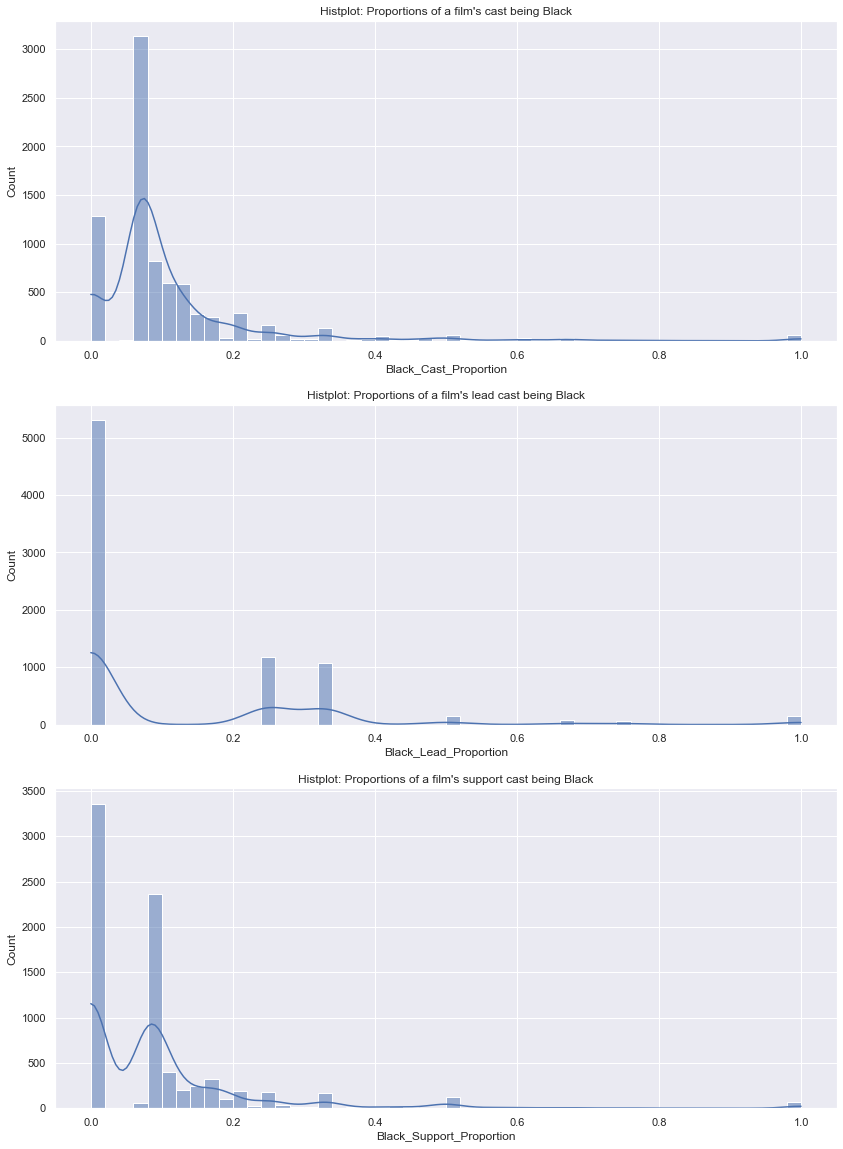

In [439]:
sns.set_theme(style="darkgrid")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 20))

sns.histplot(data=movie_data_df, x="Black_Cast_Proportion", kde=True, bins=50, ax=ax1)
ax1.set_title("Histplot: Proportions of a film's cast being Black")

sns.histplot(data=movie_data_df, x="Black_Lead_Proportion", kde=True, bins=50, ax=ax2)
ax2.set_title("Histplot: Proportions of a film's lead cast being Black")

sns.histplot(data=movie_data_df, x="Black_Support_Proportion", kde=True, bins=50, ax=ax3)
ax3.set_title("Histplot: Proportions of a film's support cast being Black")

In [440]:
# Inspect the films that are said to have no Black actors
movie_data_df[movie_data_df["Black_Cast_Proportion"] == 0.0]

,index,imdbID,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,...,Total_Awards_Lead_Actors,Total_Awards_Supporting_Actors,Total_Awards_Movie_Cast,Total_Awards_Director,Total_Awards_Writer,Total_Awards_Movie_Crew,Total_Awards_Soundtrack_Credits,Black_Lead_Proportion,Black_Support_Proportion,Black_Cast_Proportion
15,15,tt0078718,And Justice for All,1979,R,1979-10-19 00:00:00+00:00,119,"[CRIME, DRAMA, THRILLER]",[NORMAN JEWISON],"[VALERIE CURTIN, BARRY LEVINSON]",...,6,0,6,2,0,2,0,0.0,0.0,0.0
23,24,tt0081568,The Stunt Man,1980,R,1980-06-27 00:00:00+00:00,131,"[ACTION, COMEDY, DRAMA]",[RICHARD RUSH],"[LAWRENCE B. MARCUS, RICHARD RUSH, PAUL BRODEUR]",...,5,0,5,0,0,2,0,0.0,0.0,0.0
33,34,tt0084412,Night Shift,1982,R,1982-07-30 00:00:00+00:00,106,[COMEDY],[RON HOWARD],"[LOWELL GANZ, BABALOO MANDEL]",...,2,0,2,2,0,9,0,0.0,0.0,0.0
46,47,tt0086956,Best Kept Secrets,1984,Not Rated,1984-03-26 00:00:00+00:00,95,"[DRAMA, THRILLER]",[JERROLD FREEDMAN],[APRIL SMITH],...,5,0,5,0,0,0,0,0.0,0.0,0.0
48,49,tt0087015,C.H.U.D.,1984,R,1984-08-31 00:00:00+00:00,88,"[HORROR, SCI-FI]",[DOUGLAS CHEEK],"[PARNELL HALL, SHEPARD ABBOTT, CHRISTOPHER CURRY]",...,0,0,0,0,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7976,8127,tt9425078,Verotika,2019,Not Rated,2019-06-13 00:00:00+00:00,90,[HORROR],[GLENN DANZIG],[GLENN DANZIG],...,0,0,0,0,0,0,0,0.0,0.0,0.0
7977,8128,tt9426852,Taylor Swift: Reputation Stadium Tour,2018,TV-PG,2018-12-31 00:00:00+00:00,125,"[DOCUMENTARY, MUSIC]",[PAUL DUGDALE],[NAN],...,2,0,2,0,38,2,25,0.0,0.0,0.0
7992,8149,tt9690328,Paper Spiders,2020,TV-MA,2021-05-07 00:00:00+00:00,109,[DRAMA],[INON SHAMPANIER],"[INON SHAMPANIER, NATALIE SHAMPANIER]",...,0,0,0,0,0,0,0,0.0,0.0,0.0
7994,8151,tt9708358,Uncle Tom,2020,G,2020-06-19 00:00:00+00:00,106,[DOCUMENTARY],[JUSTIN MALONE],"[RYDER ANSELL, LARRY ELDER, JUSTIN MALONE]",...,0,0,0,0,0,0,0,0.0,0.0,0.0


In [441]:
movie_data_df["Movie_Cast"][15]

['AL PACINO',
 'JACK WARDEN',
 'JOHN FORSYTHE',
 'LEE STRASBERG',
 'JEFFREY TAMBOR',
 'CHRISTINE LAHTI',
 'SAM LEVENE',
 'ROBERT CHRISTIAN',
 'THOMAS G. WAITES',
 'LARRY BRYGGMAN',
 'CRAIG T. NELSON',
 'DOMINIC CHIANESE',
 'VICTOR ARNOLD',
 'VINCENT BECK',
 'MICHAEL GORRIN']

In [442]:
movie_data_df["Movie_Cast"][23]

["PETER O'TOOLE",
 'STEVE RAILSBACK',
 'BARBARA HERSHEY',
 'ALLEN GARFIELD',
 'ALEX ROCCO',
 'SHARON FARRELL',
 'ADAM ROARKE',
 'PHILIP BRUNS',
 'CHARLES BAIL',
 'JOHN GARWOOD',
 'JIM HESS',
 'JOHN PEARCE',
 'MICHAEL RAILSBACK',
 'GEORGE WALLACE',
 'DEE CARROLL']

In [443]:
movie_data_df["Movie_Cast"][7994]

['ALLEN WEST',
 'CANDACE OWENS',
 'ROBERT WOODSON',
 'BRANDON TATUM',
 'CAROL SWAIN',
 'CHAD JACKSON',
 'LARRY ELDER',
 'HERMAN CAIN',
 'EUGENE J. RALPH SR.',
 'JESSE LEE PETERSON',
 'DAMANI B. FELDER',
 'KELVIN AUSTIN',
 'PATRICIA WATSON',
 'KING FACE',
 'JOEL PATRICK']

In [444]:
actor_data_df = pd.read_pickle("actor_data_df.pkl")

In [445]:
[actor for actor in actor_data_df["actor"] if "joel" in actor]

[]

- Causes for "Black_Cast_Proportion = 0.0"
- Cause 1: Movie_Cast database data does not include the Black actors in list 
- Cause 2: Black actors in movie_cast database data but not in scraped actor_data_df
- Both causes are expected as black actors who are not in the actor_data_df most likely unknown, and if no known black actors are not in the movie_cast database data then the film is most likely not a black film.
- Therefore, all films where 'Black_Cast_Proportion' = 0.0 can be removed from the dataset.

In [446]:
# Remove films where 'Black_Cast_Proportion' = 0.0
len(movie_data_df[movie_data_df["Black_Cast_Proportion"] == 0.0])

1287

In [447]:
movie_data_df = movie_data_df[movie_data_df["Black_Cast_Proportion"] != 0.0]

Text(0.5, 1.0, "Histplot: Proportions of a film's support cast being Black")

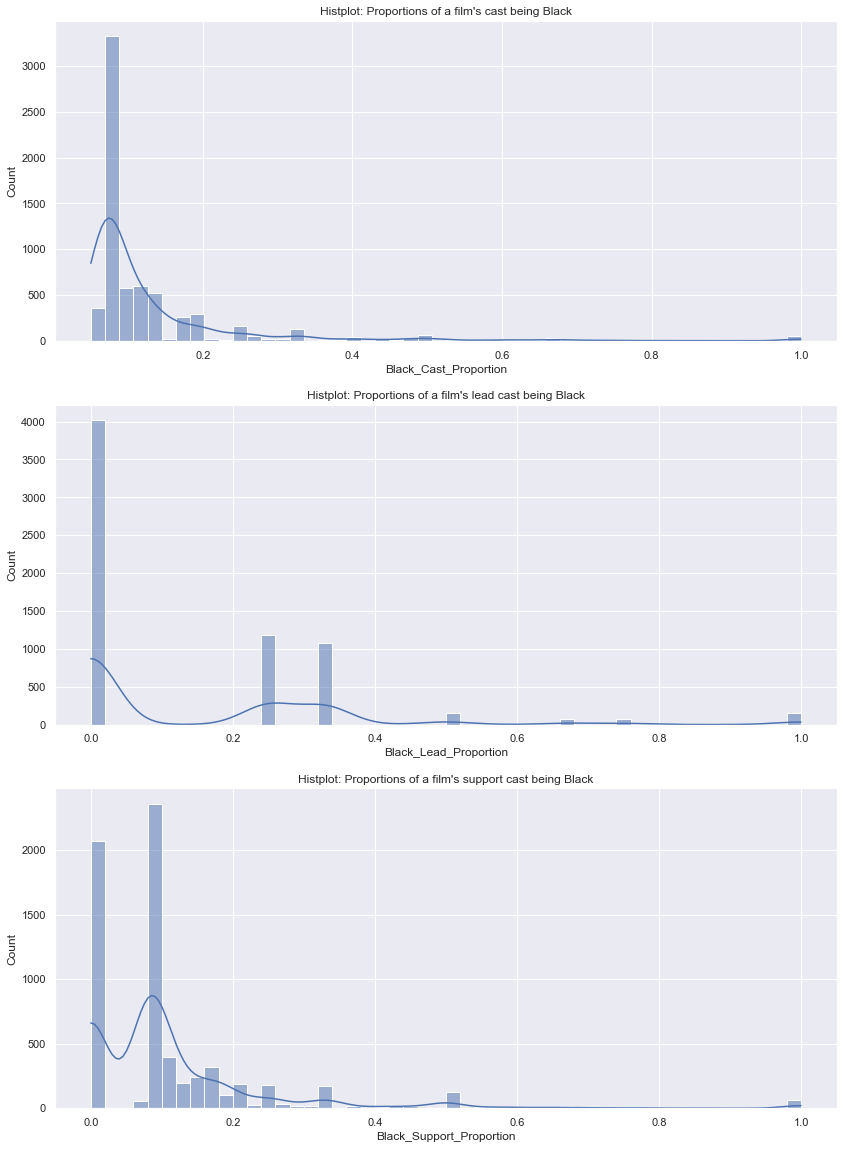

In [448]:
# Analyse proportions again
sns.set_theme(style="darkgrid")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 20))

sns.histplot(data=movie_data_df, x="Black_Cast_Proportion", kde=True, bins=50, ax=ax1)
ax1.set_title("Histplot: Proportions of a film's cast being Black")

sns.histplot(data=movie_data_df, x="Black_Lead_Proportion", kde=True, bins=50, ax=ax2)
ax2.set_title("Histplot: Proportions of a film's lead cast being Black")

sns.histplot(data=movie_data_df, x="Black_Support_Proportion", kde=True, bins=50, ax=ax3)
ax3.set_title("Histplot: Proportions of a film's support cast being Black")

In [449]:
movie_data_df[movie_data_df["Rated"].isna()]

,index,imdbID,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,...,Total_Awards_Lead_Actors,Total_Awards_Supporting_Actors,Total_Awards_Movie_Cast,Total_Awards_Director,Total_Awards_Writer,Total_Awards_Movie_Crew,Total_Awards_Soundtrack_Credits,Black_Lead_Proportion,Black_Support_Proportion,Black_Cast_Proportion
0,0,tt0056952,The Cool World,1963,None,1964-11-02 00:00:00+00:00,105,"[CRIME, DRAMA]",[SHIRLEY CLARKE],"[SHIRLEY CLARKE, CARL LEE, WARREN MILLER]",...,0,0,0,0,0,2,0,0.00,0.20,0.15
1,1,tt0065944,King: A Filmed Record... Montgomery to Memphis,1970,None,1970-03-24 00:00:00+00:00,185,"[DOCUMENTARY, BIOGRAPHY, HISTORY]","[SIDNEY LUMET, JOSEPH L. MANKIEWICZ]","[MITCHELL GRAYSON, ELY A. LANDAU]",...,10,15,25,1,0,4,0,0.50,0.08,0.18
19,20,tt0079800,The Return of Mod Squad,1979,None,1979-05-18 00:00:00+00:00,100,"[CRIME, DRAMA]",[GEORGE MCCOWAN],[ROBERT JANES],...,5,3,8,0,0,0,0,0.25,0.00,0.08
21,22,tt0081466,Scout's Honor,1980,None,1980-09-30 00:00:00+00:00,100,"[DRAMA, FAMILY, COMEDY]",[HENRY LEVIN],[BENNETT FOSTER],...,0,0,0,0,0,0,0,0.25,0.00,0.14
32,33,tt0084202,The Kid with the Broken Halo,1982,None,1982-04-05 00:00:00+00:00,100,"[COMEDY, FAMILY, FANTASY]",[LESLIE H. MARTINSON],[GEORGE KIRGO],...,2,0,2,0,0,0,0,0.50,0.40,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8010,8173,tt9820628,Film Fest,2020,None,2021-03-02 00:00:00+00:00,96,"[COMEDY, DRAMA]",[MARSHALL COOK],"[MARSHALL COOK, PAUL ALAN COPE]",...,0,0,0,0,0,0,0,0.33,0.00,0.07
8011,8175,tt9837502,Merry Men: The Real Yoruba Demons,2018,None,2018-09-28 00:00:00+00:00,106,"[ACTION, COMEDY]",[TOKA MCBAROR],[AYO MAKUN],...,0,0,0,0,0,0,0,0.00,0.09,0.07
8015,8179,tt9866112,Dispel,2019,None,2019-03-09 00:00:00+00:00,14,"[SHORT, FANTASY]",[KYLIE EATON],[KYLIE EATON],...,0,0,0,0,0,0,0,0.25,0.00,0.20
8016,8180,tt9866202,A Clear Shot,2019,None,2019-10-06 00:00:00+00:00,87,"[DRAMA, THRILLER]",[NICK LEISURE],[NICK LEISURE],...,0,0,0,0,0,0,0,0.33,0.00,0.08


In [450]:
movie_data_df["rtRating"].replace(to_replace="None", value=np.nan, inplace=True)
movie_data_df["rtRating"] = movie_data_df["rtRating"].astype(float)

In [451]:
movie_data_df["Budget"].replace(to_replace=0.0, value=np.nan, inplace=True)

In [452]:
movie_data_df["imdbRating"] = movie_data_df["imdbRating"].astype(float)

In [453]:
movie_data_df["Metascore"].replace(to_replace="None", value=np.nan, inplace=True)

In [454]:
movie_data_df["Metascore"] = movie_data_df["Metascore"].astype(float)

In [455]:
movie_data_df["Runtime"] = movie_data_df["Runtime"].astype(int)

In [456]:
movie_data_df["BoxOffice"].replace(to_replace="nan", value=np.nan, inplace=True)

In [457]:
movie_data_df["BoxOffice"] = movie_data_df["BoxOffice"].astype(float)

<AxesSubplot:xlabel='Runtime'>

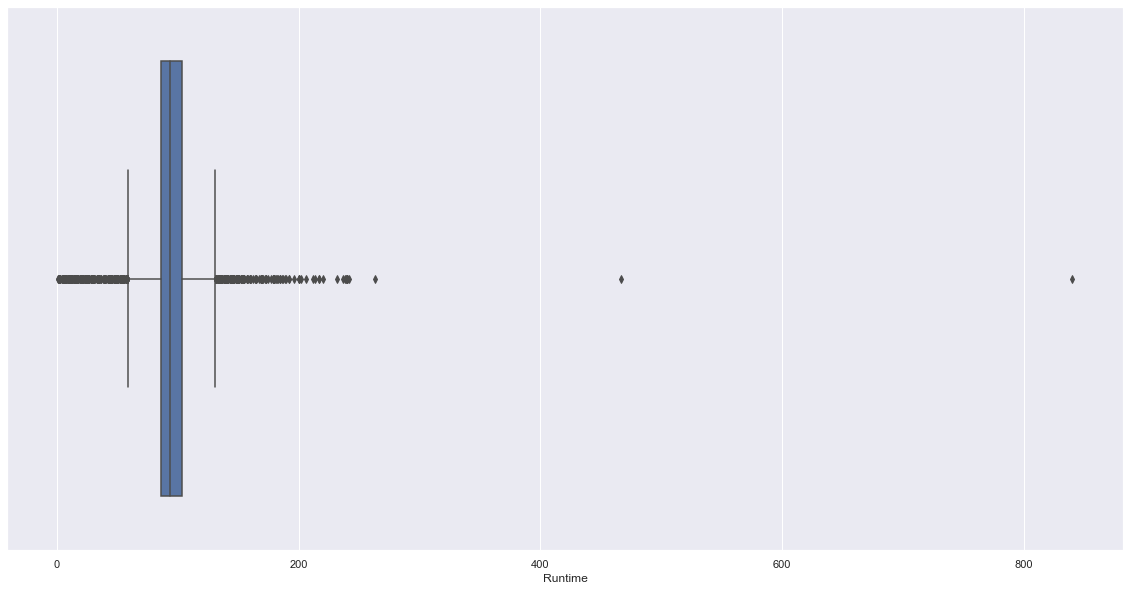

In [458]:
# Inspect the Runtime distribution
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot(data=movie_data_df, x="Runtime")

In [459]:
# Inspect "Rated"
movie_data_df["Rated"].unique()

array([None, 'X', 'R', 'PG', 'Not Rated', 'Unrated', 'TV-PG', 'PG-13',
       'TV-14', 'M', 'NOT RATED', 'G', 'TV-G', 'UNRATED', 'TV-MA',
       'Approved', 'TV-Y', 'Passed', 'APPROVED', 'M/PG', 'GP', 'NC-17',
       'TV-Y7', 'TV-Y7-FV'], dtype=object)

In [460]:
# Merge "Not Rated" variations
movie_data_df["Rated"].replace(to_replace=["Not Rated", "NOT RATED", "UNRATED"], value="Unrated", inplace=True)

In [461]:
# "APPROVED" -> "Approved"
movie_data_df["Rated"].replace(to_replace="APPROVED", value="Approved", inplace=True)

In [462]:
# Remove all TV related
movie_data_df[movie_data_df["Rated"].isin(["TV-PG", "TV-14", "TV-G", "TV-MA", "TV-Y", "TV-Y7", "TV-Y7-FV"])]

,index,imdbID,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,...,Total_Awards_Lead_Actors,Total_Awards_Supporting_Actors,Total_Awards_Movie_Cast,Total_Awards_Director,Total_Awards_Writer,Total_Awards_Movie_Crew,Total_Awards_Soundtrack_Credits,Black_Lead_Proportion,Black_Support_Proportion,Black_Cast_Proportion
58,59,tt0089815,Playing with Fire,1985,TV-PG,1985-04-14 00:00:00+00:00,100,"[CRIME, DRAMA]",[IVAN NAGY],[LEW HUNTER],...,1,0,1,0,0,0,0,1.00,0.09,0.33
84,85,tt0093141,Hands of a Stranger,1987,TV-14,1987-05-10 00:00:00+00:00,130,"[CRIME, DRAMA, ROMANCE, THRILLER]",[LARRY ELIKANN],"[ROBERT DALEY, ARTHUR KOPIT]",...,3,0,3,0,0,0,0,0.00,0.11,0.08
120,121,tt0097402,Full Exposure: The Sex Tapes Scandal,1989,TV-PG,1989-02-05 00:00:00+00:00,92,[THRILLER],[NOEL NOSSECK],[STEPHEN ZITO],...,0,0,0,0,0,0,0,0.25,0.33,0.29
195,198,tt0106578,Class of '61,1993,TV-PG,1993-04-12 00:00:00+00:00,95,"[ACTION, ADVENTURE, DRAMA]",[GREGORY HOBLIT],[JONAS MCCORD],...,0,0,0,0,0,6,0,0.25,0.12,0.17
222,225,tt0108580,Without Warning: Terror in the Towers,1993,TV-PG,1993-05-26 00:00:00+00:00,96,[DRAMA],[ALAN J. LEVI],"[STEPHEN DOWNING, DUANE POOLE]",...,0,2,2,0,0,0,0,0.50,0.00,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8009,8171,tt9815588,Suburban Swingers Club,2019,TV-14,2019-03-09 00:00:00+00:00,85,[DRAMA],[JESSICA JANOS],"[CHRISTOFF BERGESON, KEN SANDERS, MARK SANDERSON]",...,0,0,0,0,0,0,0,0.25,0.00,0.20
8013,8177,tt9860728,Falling Inn Love,2019,TV-PG,2019-08-29 00:00:00+00:00,98,"[COMEDY, ROMANCE]",[ROGER KUMBLE],"[ELIZABETH HACKETT, HILARY GALANOY]",...,0,0,0,0,0,0,0,0.33,0.00,0.07
8014,8178,tt9866072,Holidate,2020,TV-MA,2020-10-28 00:00:00+00:00,104,"[COMEDY, ROMANCE]",[JOHN WHITESELL],[TIFFANY PAULSEN],...,0,0,0,0,0,9,13,0.00,0.08,0.07
8017,8182,tt9876426,Love Takes Flight,2019,TV-G,2019-04-27 00:00:00+00:00,87,[ROMANCE],[STEVEN R. MONROE],[ERIC BROOKS],...,0,0,0,0,0,0,15,0.00,0.09,0.07


In [463]:
# Check against validation set
movie_data_df_check = movie_data_df[~movie_data_df["Rated"].isin(["TV-PG", "TV-14", "TV-G", "TV-MA", "TV-Y", "TV-Y7", "TV-Y7-FV"])]

In [464]:
current_list = movie_data_df_check["Title"].to_list()

In [465]:
# Normalise titles in both lists
current_list = [title.strip().lower() for title in current_list]
merged_list = [title.strip().lower() for title in merged_list]

# Get the difference in titles
list_difference = [title for title in merged_list if title not in current_list]
print(f'There are {len(list_difference)} titles missing from the movie data.') 

There are 127 titles missing from the movie data.


In [466]:
movie_data_df = movie_data_df[~movie_data_df["Rated"].isin(["TV-PG", "TV-14", "TV-G", "TV-MA", "TV-Y", "TV-Y7", "TV-Y7-FV"])]

In [467]:
movie_data_df

,index,imdbID,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,...,Total_Awards_Lead_Actors,Total_Awards_Supporting_Actors,Total_Awards_Movie_Cast,Total_Awards_Director,Total_Awards_Writer,Total_Awards_Movie_Crew,Total_Awards_Soundtrack_Credits,Black_Lead_Proportion,Black_Support_Proportion,Black_Cast_Proportion
0,0,tt0056952,The Cool World,1963,None,1964-11-02 00:00:00+00:00,105,"[CRIME, DRAMA]",[SHIRLEY CLARKE],"[SHIRLEY CLARKE, CARL LEE, WARREN MILLER]",...,0,0,0,0,0,2,0,0.00,0.20,0.15
1,1,tt0065944,King: A Filmed Record... Montgomery to Memphis,1970,None,1970-03-24 00:00:00+00:00,185,"[DOCUMENTARY, BIOGRAPHY, HISTORY]","[SIDNEY LUMET, JOSEPH L. MANKIEWICZ]","[MITCHELL GRAYSON, ELY A. LANDAU]",...,10,15,25,1,0,4,0,0.50,0.08,0.18
2,2,tt0066559,What Do You Say to a Naked Lady?,1970,X,1970-02-18 00:00:00+00:00,85,"[DOCUMENTARY, COMEDY]",[ALLEN FUNT],[ALLEN FUNT],...,0,0,0,0,0,0,0,0.00,0.12,0.08
3,3,tt0067741,Shaft,1971,R,1971-07-02 00:00:00+00:00,100,"[ACTION, CRIME, THRILLER]",[GORDON PARKS],"[ERNEST TIDYMAN, JOHN D.F. BLACK, ERNEST TIDYMAN]",...,0,0,0,0,0,3,0,0.50,0.00,0.13
4,4,tt0068358,Charley-One-Eye,1973,R,1973-04-18 00:00:00+00:00,96,[WESTERN],[DON CHAFFEY],[KEITH LEONARD],...,1,0,1,0,0,2,0,0.25,0.00,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8015,8179,tt9866112,Dispel,2019,None,2019-03-09 00:00:00+00:00,14,"[SHORT, FANTASY]",[KYLIE EATON],[KYLIE EATON],...,0,0,0,0,0,0,0,0.25,0.00,0.20
8016,8180,tt9866202,A Clear Shot,2019,None,2019-10-06 00:00:00+00:00,87,"[DRAMA, THRILLER]",[NICK LEISURE],[NICK LEISURE],...,0,0,0,0,0,0,0,0.33,0.00,0.08
8018,8184,tt9883024,Tribes,2020,None,2020-01-23 00:00:00+00:00,11,"[SHORT, COMEDY]",[NINO ALDI],[ANDY MARLATT],...,0,0,0,0,0,0,0,0.00,0.09,0.07
8019,8185,tt9887580,Bulletproof 2,2020,Unrated,2020-01-07 00:00:00+00:00,97,"[ACTION, COMEDY]",[DON MICHAEL PAUL],"[DON MICHAEL PAUL, RICH WILKES]",...,0,0,0,0,0,0,0,0.33,0.00,0.10


<AxesSubplot:xlabel='Runtime'>

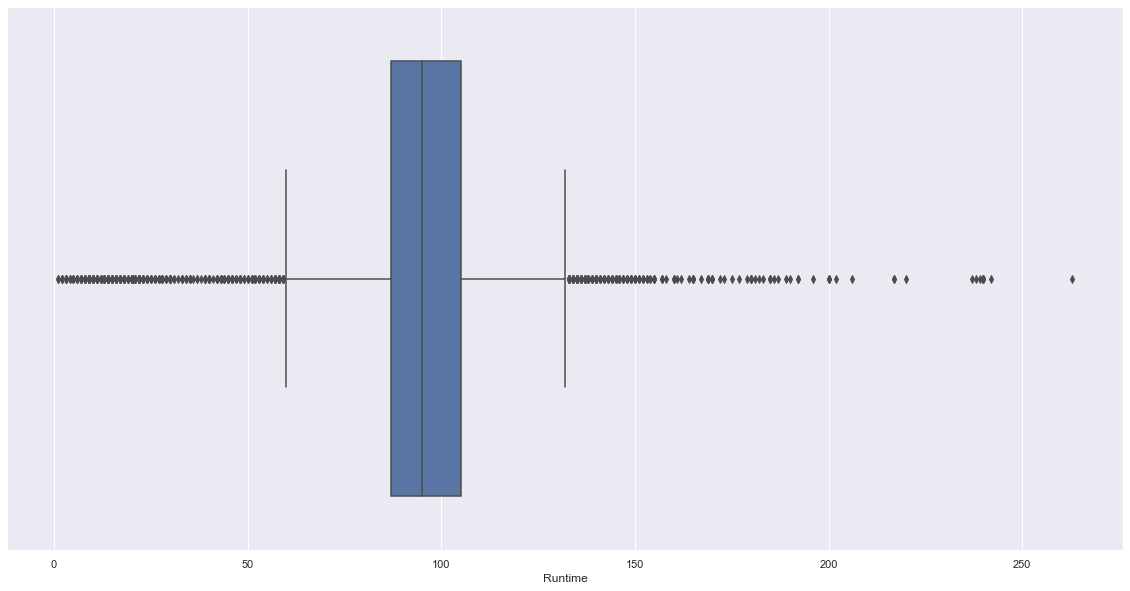

In [468]:
# Inspect the Runtime distribution again
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot(data=movie_data_df, x="Runtime")

In [469]:
# Inspect movies under 60 mins
movie_data_df[movie_data_df["Runtime"] < 60]

,index,imdbID,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,...,Total_Awards_Lead_Actors,Total_Awards_Supporting_Actors,Total_Awards_Movie_Cast,Total_Awards_Director,Total_Awards_Writer,Total_Awards_Movie_Crew,Total_Awards_Soundtrack_Credits,Black_Lead_Proportion,Black_Support_Proportion,Black_Cast_Proportion
88,89,tt0093537,The Mighty Pawns,1987,None,1987-02-14 00:00:00+00:00,57,[DRAMA],[ERIC LANEUVILLE],[STEWART BIRD],...,0,0,0,0,0,0,0,0.25,0.33,0.29
263,266,tt0113493,Judgement,1995,None,1995-12-31 00:00:00+00:00,31,"[CRIME, DRAMA, THRILLER, SHORT]",[DAVID WINKLER],"[NELSON MCCORMICK, DAVID WINKLER]",...,0,0,0,0,0,1,0,0.25,0.00,0.17
414,418,tt0144827,John Grin's Christmas,1986,None,1986-12-06 00:00:00+00:00,50,[FAMILY],[ROBERT GUILLAUME],"[CHARLES DICKENS (STORY ""A CHRISTMAS CAROL""), ...",...,3,0,3,3,0,3,0,0.75,0.00,0.60
563,573,tt0261220,Raisins Sold Out: The California Raisins II,1990,None,1990-05-02 00:00:00+00:00,24,"[ANIMATION, COMEDY, MUSIC]",[WILL VINTON],[ROWBY GOREN],...,0,0,0,1,0,1,0,0.00,0.33,0.14
583,595,tt0274525,"Gina, an Actress, Age 29",2001,None,2001-01-20 00:00:00+00:00,22,"[SHORT, COMEDY, DRAMA]",[PAUL HARRILL],[PAUL HARRILL],...,0,0,0,0,0,0,0,0.33,0.00,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7944,8088,tt9184698,Guilty Until Proven Guilty,2018,None,2018-10-20 00:00:00+00:00,53,[DOCUMENTARY],[HARRY MOSES],[NAN],...,1,0,1,0,38,0,0,0.50,0.00,0.33
7950,8094,tt9223978,Dominant Chord,2019,None,2019-09-21 00:00:00+00:00,9,"[SHORT, DRAMA]",[JEREMY LEROUX],[JEREMY LEROUX],...,0,0,0,0,0,0,0,0.25,0.00,0.20
7972,8120,tt9386016,Vert,2019,None,2020-06-01 00:00:00+00:00,13,"[SHORT, DRAMA]",[KATE COX],[KATE COX],...,0,0,0,0,0,0,0,0.33,0.00,0.33
8015,8179,tt9866112,Dispel,2019,None,2019-03-09 00:00:00+00:00,14,"[SHORT, FANTASY]",[KYLIE EATON],[KYLIE EATON],...,0,0,0,0,0,0,0,0.25,0.00,0.20


In [470]:
# Check against validation set
movie_data_df_check = movie_data_df[movie_data_df["Runtime"] >= 60]
current_list = movie_data_df_check["Title"].to_list()

# Normalise titles in both lists
current_list = [title.strip().lower() for title in current_list]
merged_list = [title.strip().lower() for title in merged_list]

# Get the difference in titles
list_difference = [title for title in merged_list if title not in current_list]
print(f'There are {len(list_difference)} titles missing from the movie data.') 

There are 127 titles missing from the movie data.


In [471]:
# Update dataset
movie_data_df = movie_data_df[movie_data_df["Runtime"] >= 60]

In [472]:
movie_data_df

,index,imdbID,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,...,Total_Awards_Lead_Actors,Total_Awards_Supporting_Actors,Total_Awards_Movie_Cast,Total_Awards_Director,Total_Awards_Writer,Total_Awards_Movie_Crew,Total_Awards_Soundtrack_Credits,Black_Lead_Proportion,Black_Support_Proportion,Black_Cast_Proportion
0,0,tt0056952,The Cool World,1963,None,1964-11-02 00:00:00+00:00,105,"[CRIME, DRAMA]",[SHIRLEY CLARKE],"[SHIRLEY CLARKE, CARL LEE, WARREN MILLER]",...,0,0,0,0,0,2,0,0.00,0.20,0.15
1,1,tt0065944,King: A Filmed Record... Montgomery to Memphis,1970,None,1970-03-24 00:00:00+00:00,185,"[DOCUMENTARY, BIOGRAPHY, HISTORY]","[SIDNEY LUMET, JOSEPH L. MANKIEWICZ]","[MITCHELL GRAYSON, ELY A. LANDAU]",...,10,15,25,1,0,4,0,0.50,0.08,0.18
2,2,tt0066559,What Do You Say to a Naked Lady?,1970,X,1970-02-18 00:00:00+00:00,85,"[DOCUMENTARY, COMEDY]",[ALLEN FUNT],[ALLEN FUNT],...,0,0,0,0,0,0,0,0.00,0.12,0.08
3,3,tt0067741,Shaft,1971,R,1971-07-02 00:00:00+00:00,100,"[ACTION, CRIME, THRILLER]",[GORDON PARKS],"[ERNEST TIDYMAN, JOHN D.F. BLACK, ERNEST TIDYMAN]",...,0,0,0,0,0,3,0,0.50,0.00,0.13
4,4,tt0068358,Charley-One-Eye,1973,R,1973-04-18 00:00:00+00:00,96,[WESTERN],[DON CHAFFEY],[KEITH LEONARD],...,1,0,1,0,0,2,0,0.25,0.00,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8011,8175,tt9837502,Merry Men: The Real Yoruba Demons,2018,None,2018-09-28 00:00:00+00:00,106,"[ACTION, COMEDY]",[TOKA MCBAROR],[AYO MAKUN],...,0,0,0,0,0,0,0,0.00,0.09,0.07
8012,8176,tt9844522,Escape Room: Tournament of Champions,2021,PG-13,2021-07-16 00:00:00+00:00,88,"[ACTION, ADVENTURE, HORROR]",[ADAM ROBITEL],"[WILL HONLEY, MARIA MELNIK, DANIEL TUCH]",...,0,0,0,0,0,0,0,0.33,0.00,0.08
8016,8180,tt9866202,A Clear Shot,2019,None,2019-10-06 00:00:00+00:00,87,"[DRAMA, THRILLER]",[NICK LEISURE],[NICK LEISURE],...,0,0,0,0,0,0,0,0.33,0.00,0.08
8019,8185,tt9887580,Bulletproof 2,2020,Unrated,2020-01-07 00:00:00+00:00,97,"[ACTION, COMEDY]",[DON MICHAEL PAUL],"[DON MICHAEL PAUL, RICH WILKES]",...,0,0,0,0,0,0,0,0.33,0.00,0.10


Text(0.5, 1.0, "Histplot: Proportions of a film's support cast being Black")

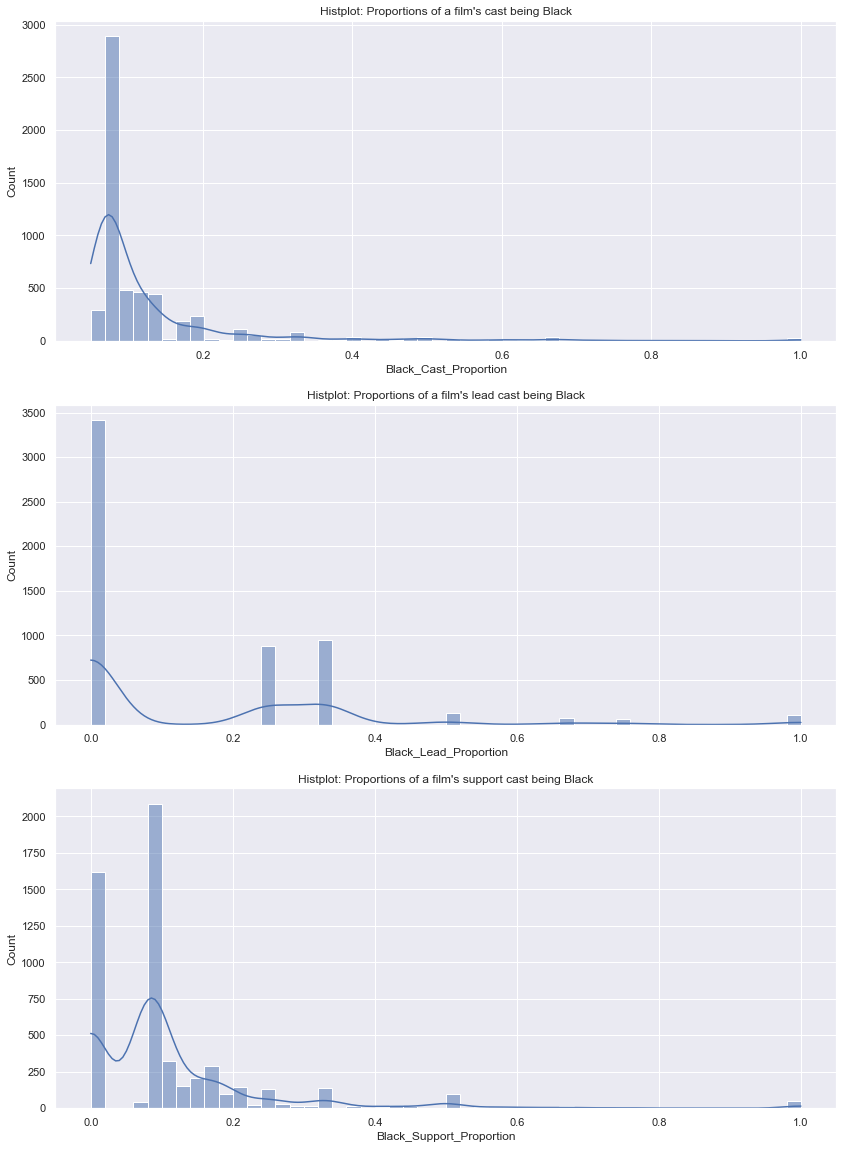

In [473]:
# Analyse proportions again
sns.set_theme(style="darkgrid")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 20))

sns.histplot(data=movie_data_df, x="Black_Cast_Proportion", kde=True, bins=50, ax=ax1)
ax1.set_title("Histplot: Proportions of a film's cast being Black")

sns.histplot(data=movie_data_df, x="Black_Lead_Proportion", kde=True, bins=50, ax=ax2)
ax2.set_title("Histplot: Proportions of a film's lead cast being Black")

sns.histplot(data=movie_data_df, x="Black_Support_Proportion", kde=True, bins=50, ax=ax3)
ax3.set_title("Histplot: Proportions of a film's support cast being Black")

In [474]:
# Inspect films with no black supporting actors 
movie_data_df[(movie_data_df["Black_Support_Proportion"] == 0.0)]["Black_Lead_Proportion"].unique()

array([0.5 , 0.25, 0.67, 0.33, 0.75, 1.  ])

In [475]:
movie_data_df[(movie_data_df["Black_Support_Proportion"] == 0.0)]["Black_Cast_Proportion"].unique()

array([0.13, 0.12, 0.08, 0.09, 0.14, 0.07, 0.11, 0.4 , 0.25, 0.06, 0.1 ,
       0.29, 0.2 , 0.3 , 0.15, 0.22, 0.33, 0.17, 0.5 , 0.27, 0.18, 0.6 ,
       0.38, 0.43, 1.  , 0.57, 0.75, 0.67])

In [487]:
movie_data_df[(movie_data_df["Black_Support_Proportion"] >= 0.1) | (movie_data_df["Black_Lead_Proportion"] != 0.0)]

,index,imdbID,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,...,Total_Awards_Lead_Actors,Total_Awards_Supporting_Actors,Total_Awards_Movie_Cast,Total_Awards_Director,Total_Awards_Writer,Total_Awards_Movie_Crew,Total_Awards_Soundtrack_Credits,Black_Lead_Proportion,Black_Support_Proportion,Black_Cast_Proportion
0,0,tt0056952,The Cool World,1963,None,1964-11-02 00:00:00+00:00,105,"[CRIME, DRAMA]",[SHIRLEY CLARKE],"[SHIRLEY CLARKE, CARL LEE, WARREN MILLER]",...,0,0,0,0,0,2,0,0.00,0.20,0.15
1,1,tt0065944,King: A Filmed Record... Montgomery to Memphis,1970,None,1970-03-24 00:00:00+00:00,185,"[DOCUMENTARY, BIOGRAPHY, HISTORY]","[SIDNEY LUMET, JOSEPH L. MANKIEWICZ]","[MITCHELL GRAYSON, ELY A. LANDAU]",...,10,15,25,1,0,4,0,0.50,0.08,0.18
2,2,tt0066559,What Do You Say to a Naked Lady?,1970,X,1970-02-18 00:00:00+00:00,85,"[DOCUMENTARY, COMEDY]",[ALLEN FUNT],[ALLEN FUNT],...,0,0,0,0,0,0,0,0.00,0.12,0.08
3,3,tt0067741,Shaft,1971,R,1971-07-02 00:00:00+00:00,100,"[ACTION, CRIME, THRILLER]",[GORDON PARKS],"[ERNEST TIDYMAN, JOHN D.F. BLACK, ERNEST TIDYMAN]",...,0,0,0,0,0,3,0,0.50,0.00,0.13
4,4,tt0068358,Charley-One-Eye,1973,R,1973-04-18 00:00:00+00:00,96,[WESTERN],[DON CHAFFEY],[KEITH LEONARD],...,1,0,1,0,0,2,0,0.25,0.00,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8010,8173,tt9820628,Film Fest,2020,None,2021-03-02 00:00:00+00:00,96,"[COMEDY, DRAMA]",[MARSHALL COOK],"[MARSHALL COOK, PAUL ALAN COPE]",...,0,0,0,0,0,0,0,0.33,0.00,0.07
8011,8175,tt9837502,Merry Men: The Real Yoruba Demons,2018,None,2018-09-28 00:00:00+00:00,106,"[ACTION, COMEDY]",[TOKA MCBAROR],[AYO MAKUN],...,0,0,0,0,0,0,0,0.00,0.09,0.07
8012,8176,tt9844522,Escape Room: Tournament of Champions,2021,PG-13,2021-07-16 00:00:00+00:00,88,"[ACTION, ADVENTURE, HORROR]",[ADAM ROBITEL],"[WILL HONLEY, MARIA MELNIK, DANIEL TUCH]",...,0,0,0,0,0,0,0,0.33,0.00,0.08
8016,8180,tt9866202,A Clear Shot,2019,None,2019-10-06 00:00:00+00:00,87,"[DRAMA, THRILLER]",[NICK LEISURE],[NICK LEISURE],...,0,0,0,0,0,0,0,0.33,0.00,0.08


In [489]:
# Check against validation set
movie_data_df_check = movie_data_df[(movie_data_df["Black_Support_Proportion"] >= 0.1) | (movie_data_df["Black_Lead_Proportion"] != 0.0)]
current_list = movie_data_df_check["Title"].to_list()

# Normalise titles in both lists
current_list = [title.strip().lower() for title in current_list]
merged_list = [title.strip().lower() for title in merged_list]

# Get the difference in titles
list_difference = [title for title in merged_list if title not in current_list]
print(f'There are {len(list_difference)} titles missing from the movie data.') 

There are 132 titles missing from the movie data.


In [490]:
# Update dataset
movie_data_df = movie_data_df[(movie_data_df["Black_Support_Proportion"] >= 0.1) | (movie_data_df["Black_Lead_Proportion"] != 0.0)]

In [491]:
movie_data_df

,index,imdbID,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,...,Total_Awards_Lead_Actors,Total_Awards_Supporting_Actors,Total_Awards_Movie_Cast,Total_Awards_Director,Total_Awards_Writer,Total_Awards_Movie_Crew,Total_Awards_Soundtrack_Credits,Black_Lead_Proportion,Black_Support_Proportion,Black_Cast_Proportion
0,0,tt0056952,The Cool World,1963,None,1964-11-02 00:00:00+00:00,105,"[CRIME, DRAMA]",[SHIRLEY CLARKE],"[SHIRLEY CLARKE, CARL LEE, WARREN MILLER]",...,0,0,0,0,0,2,0,0.00,0.20,0.15
1,1,tt0065944,King: A Filmed Record... Montgomery to Memphis,1970,None,1970-03-24 00:00:00+00:00,185,"[DOCUMENTARY, BIOGRAPHY, HISTORY]","[SIDNEY LUMET, JOSEPH L. MANKIEWICZ]","[MITCHELL GRAYSON, ELY A. LANDAU]",...,10,15,25,1,0,4,0,0.50,0.08,0.18
2,2,tt0066559,What Do You Say to a Naked Lady?,1970,X,1970-02-18 00:00:00+00:00,85,"[DOCUMENTARY, COMEDY]",[ALLEN FUNT],[ALLEN FUNT],...,0,0,0,0,0,0,0,0.00,0.12,0.08
3,3,tt0067741,Shaft,1971,R,1971-07-02 00:00:00+00:00,100,"[ACTION, CRIME, THRILLER]",[GORDON PARKS],"[ERNEST TIDYMAN, JOHN D.F. BLACK, ERNEST TIDYMAN]",...,0,0,0,0,0,3,0,0.50,0.00,0.13
4,4,tt0068358,Charley-One-Eye,1973,R,1973-04-18 00:00:00+00:00,96,[WESTERN],[DON CHAFFEY],[KEITH LEONARD],...,1,0,1,0,0,2,0,0.25,0.00,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8004,8164,tt9772704,My Mom's Letter from Heaven,2019,None,2019-04-20 00:00:00+00:00,87,[FAMILY],[MICHAEL M. SCOTT],[LISA DI TROLIO],...,0,0,0,0,0,0,0,0.25,0.00,0.08
8010,8173,tt9820628,Film Fest,2020,None,2021-03-02 00:00:00+00:00,96,"[COMEDY, DRAMA]",[MARSHALL COOK],"[MARSHALL COOK, PAUL ALAN COPE]",...,0,0,0,0,0,0,0,0.33,0.00,0.07
8012,8176,tt9844522,Escape Room: Tournament of Champions,2021,PG-13,2021-07-16 00:00:00+00:00,88,"[ACTION, ADVENTURE, HORROR]",[ADAM ROBITEL],"[WILL HONLEY, MARIA MELNIK, DANIEL TUCH]",...,0,0,0,0,0,0,0,0.33,0.00,0.08
8016,8180,tt9866202,A Clear Shot,2019,None,2019-10-06 00:00:00+00:00,87,"[DRAMA, THRILLER]",[NICK LEISURE],[NICK LEISURE],...,0,0,0,0,0,0,0,0.33,0.00,0.08


Text(0.5, 1.0, "Histplot: Proportions of a film's support cast being Black")

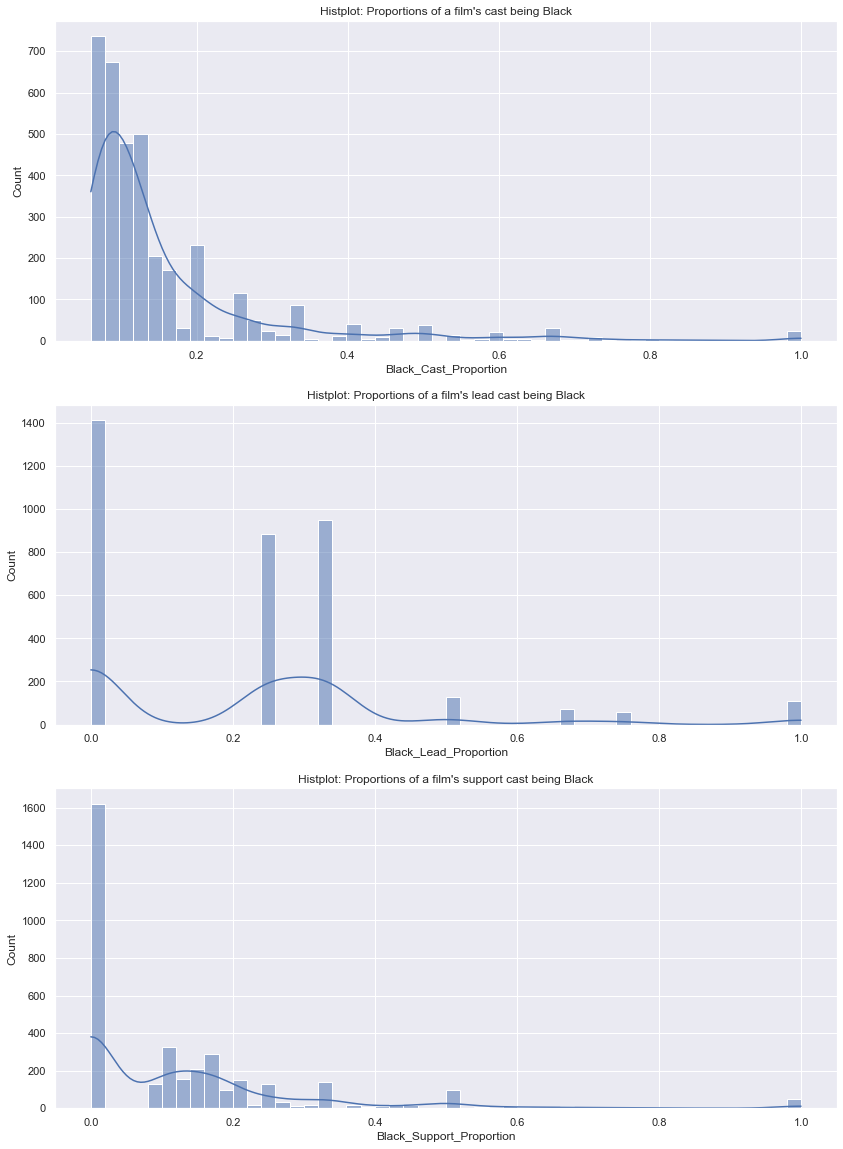

In [492]:
# Analyse proportions again
sns.set_theme(style="darkgrid")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 20))

sns.histplot(data=movie_data_df, x="Black_Cast_Proportion", kde=True, bins=50, ax=ax1)
ax1.set_title("Histplot: Proportions of a film's cast being Black")

sns.histplot(data=movie_data_df, x="Black_Lead_Proportion", kde=True, bins=50, ax=ax2)
ax2.set_title("Histplot: Proportions of a film's lead cast being Black")

sns.histplot(data=movie_data_df, x="Black_Support_Proportion", kde=True, bins=50, ax=ax3)
ax3.set_title("Histplot: Proportions of a film's support cast being Black")

In [498]:
movie_data_df["Title"].to_list()

['The Cool World',
 'King: A Filmed Record... Montgomery to Memphis',
 'What Do You Say to a Naked Lady?',
 'Shaft',
 'Charley-One-Eye',
 'Embassy',
 'Firehouse',
 "Shaft's Big Score!",
 'Shaft in Africa',
 'Diamonds',
 'Man Friday',
 'Portrait of a Hitman',
 'Day of the Assassin',
 'Game for Vultures',
 'The Return of Mod Squad',
 "Scout's Honor",
 'Silver Dream Racer',
 'An Eye for an Eye',
 'On the Right Track',
 'Ragtime',
 'Cat People',
 'The Kid with the Broken Halo',
 'Permanent Vacation',
 'Antony and Cleopatra',
 'The Big Score',
 'Jimmy the Kid',
 'The Kid with the 200 I.Q.',
 'One Down, Two to go',
 'Young Warriors',
 'Alphabet City',
 'The Brother from Another Planet',
 'City Heat',
 'Exterminator 2',
 'The Fantastic World of D.C. Collins',
 'Killpoint',
 'Kicks',
 'Trouble in Mind',
 '52 Pick-Up',
 '8 Million Ways to Die',
 'Condor',
 'Crossroads',
 'Extremities',
 'The Fifth Missile',
 'Kidnapped',
 'Manhunter',
 'Maximum Overdrive',
 'Platoon',
 'Ratboy',
 'Samaritan: Th

In [506]:
movie_data_df.reset_index(drop=True, inplace=True)

In [507]:
movie_data_df

,index,imdbID,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,...,Total_Awards_Lead_Actors,Total_Awards_Supporting_Actors,Total_Awards_Movie_Cast,Total_Awards_Director,Total_Awards_Writer,Total_Awards_Movie_Crew,Total_Awards_Soundtrack_Credits,Black_Lead_Proportion,Black_Support_Proportion,Black_Cast_Proportion
0,0,tt0056952,The Cool World,1963,None,1964-11-02 00:00:00+00:00,105,"[CRIME, DRAMA]",[SHIRLEY CLARKE],"[SHIRLEY CLARKE, CARL LEE, WARREN MILLER]",...,0,0,0,0,0,2,0,0.00,0.20,0.15
1,1,tt0065944,King: A Filmed Record... Montgomery to Memphis,1970,None,1970-03-24 00:00:00+00:00,185,"[DOCUMENTARY, BIOGRAPHY, HISTORY]","[SIDNEY LUMET, JOSEPH L. MANKIEWICZ]","[MITCHELL GRAYSON, ELY A. LANDAU]",...,10,15,25,1,0,4,0,0.50,0.08,0.18
2,2,tt0066559,What Do You Say to a Naked Lady?,1970,X,1970-02-18 00:00:00+00:00,85,"[DOCUMENTARY, COMEDY]",[ALLEN FUNT],[ALLEN FUNT],...,0,0,0,0,0,0,0,0.00,0.12,0.08
3,3,tt0067741,Shaft,1971,R,1971-07-02 00:00:00+00:00,100,"[ACTION, CRIME, THRILLER]",[GORDON PARKS],"[ERNEST TIDYMAN, JOHN D.F. BLACK, ERNEST TIDYMAN]",...,0,0,0,0,0,3,0,0.50,0.00,0.13
4,4,tt0068358,Charley-One-Eye,1973,R,1973-04-18 00:00:00+00:00,96,[WESTERN],[DON CHAFFEY],[KEITH LEONARD],...,1,0,1,0,0,2,0,0.25,0.00,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3609,8164,tt9772704,My Mom's Letter from Heaven,2019,None,2019-04-20 00:00:00+00:00,87,[FAMILY],[MICHAEL M. SCOTT],[LISA DI TROLIO],...,0,0,0,0,0,0,0,0.25,0.00,0.08
3610,8173,tt9820628,Film Fest,2020,None,2021-03-02 00:00:00+00:00,96,"[COMEDY, DRAMA]",[MARSHALL COOK],"[MARSHALL COOK, PAUL ALAN COPE]",...,0,0,0,0,0,0,0,0.33,0.00,0.07
3611,8176,tt9844522,Escape Room: Tournament of Champions,2021,PG-13,2021-07-16 00:00:00+00:00,88,"[ACTION, ADVENTURE, HORROR]",[ADAM ROBITEL],"[WILL HONLEY, MARIA MELNIK, DANIEL TUCH]",...,0,0,0,0,0,0,0,0.33,0.00,0.08
3612,8180,tt9866202,A Clear Shot,2019,None,2019-10-06 00:00:00+00:00,87,"[DRAMA, THRILLER]",[NICK LEISURE],[NICK LEISURE],...,0,0,0,0,0,0,0,0.33,0.00,0.08


In [ ]:
# Inspect low Black actor proportions 
movie_data_df[(movie_data_df["Black_Lead_Proportion"] < 0.5) & (movie_data_df["Black_Support_Proportion"] < 0.1) & (movie_data_df["Black_Cast_Proportion"] < 0.1)]

In [530]:
# Get indexes
indexes_to_remove = movie_data_df[(movie_data_df["Black_Lead_Proportion"] < 0.5) & (movie_data_df["Black_Support_Proportion"] < 0.1) & (movie_data_df["Black_Cast_Proportion"] < 0.1)].index

In [534]:
# Update dataframe
movie_data_df = movie_data_df.loc[~movie_data_df.index.isin(indexes_to_remove)]

In [536]:
# Check against validation set
current_list = movie_data_df["Title"].to_list()

# Normalise titles in both lists
current_list = [title.strip().lower() for title in current_list]
merged_list = [title.strip().lower() for title in merged_list]

# Get the difference in titles
list_difference = [title for title in merged_list if title not in current_list]
print(f'There are {len(list_difference)} titles missing from the movie data.') 

There are 139 titles missing from the movie data.


In [538]:
movie_data_df.reset_index(drop=True, inplace=True)

In [539]:
movie_data_df

,index,imdbID,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,...,Total_Awards_Lead_Actors,Total_Awards_Supporting_Actors,Total_Awards_Movie_Cast,Total_Awards_Director,Total_Awards_Writer,Total_Awards_Movie_Crew,Total_Awards_Soundtrack_Credits,Black_Lead_Proportion,Black_Support_Proportion,Black_Cast_Proportion
0,0,tt0056952,The Cool World,1963,None,1964-11-02 00:00:00+00:00,105,"[CRIME, DRAMA]",[SHIRLEY CLARKE],"[SHIRLEY CLARKE, CARL LEE, WARREN MILLER]",...,0,0,0,0,0,2,0,0.00,0.20,0.15
1,1,tt0065944,King: A Filmed Record... Montgomery to Memphis,1970,None,1970-03-24 00:00:00+00:00,185,"[DOCUMENTARY, BIOGRAPHY, HISTORY]","[SIDNEY LUMET, JOSEPH L. MANKIEWICZ]","[MITCHELL GRAYSON, ELY A. LANDAU]",...,10,15,25,1,0,4,0,0.50,0.08,0.18
2,2,tt0066559,What Do You Say to a Naked Lady?,1970,X,1970-02-18 00:00:00+00:00,85,"[DOCUMENTARY, COMEDY]",[ALLEN FUNT],[ALLEN FUNT],...,0,0,0,0,0,0,0,0.00,0.12,0.08
3,3,tt0067741,Shaft,1971,R,1971-07-02 00:00:00+00:00,100,"[ACTION, CRIME, THRILLER]",[GORDON PARKS],"[ERNEST TIDYMAN, JOHN D.F. BLACK, ERNEST TIDYMAN]",...,0,0,0,0,0,3,0,0.50,0.00,0.13
4,4,tt0068358,Charley-One-Eye,1973,R,1973-04-18 00:00:00+00:00,96,[WESTERN],[DON CHAFFEY],[KEITH LEONARD],...,1,0,1,0,0,2,0,0.25,0.00,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2710,8147,tt9677806,Peter Lindbergh - Women's Stories,2019,None,2019-05-30 00:00:00+00:00,113,[DOCUMENTARY],[JEAN-MICHEL VECCHIET],[NAN],...,0,0,0,0,38,0,0,0.33,0.00,0.17
2711,8148,tt9684220,Bad Trip,2021,Unrated,2021-03-26 00:00:00+00:00,86,[COMEDY],[KITAO SAKURAI],"[ERIC ANDRÉ, KITAO SAKURAI, ANDREW BARCHILON]",...,0,0,0,0,0,1,18,0.00,0.17,0.11
2712,8160,tt9760132,Amish Abduction,2019,None,2019-11-09 00:00:00+00:00,87,[THRILLER],[ALI LIEBERT],[ERIC WEINSTOCK],...,0,0,0,0,0,0,0,0.00,0.17,0.10
2713,8162,tt9763402,The Misadventures of Mistress Maneater,2020,None,2020-10-30 00:00:00+00:00,111,"[ACTION, COMEDY, ROMANCE]",[C.J. JULIANUS],[LORRISA JULIANUS],...,0,0,0,0,0,0,0,0.00,0.12,0.09


Text(0.5, 1.0, "Histplot: Proportions of a film's support cast being Black")

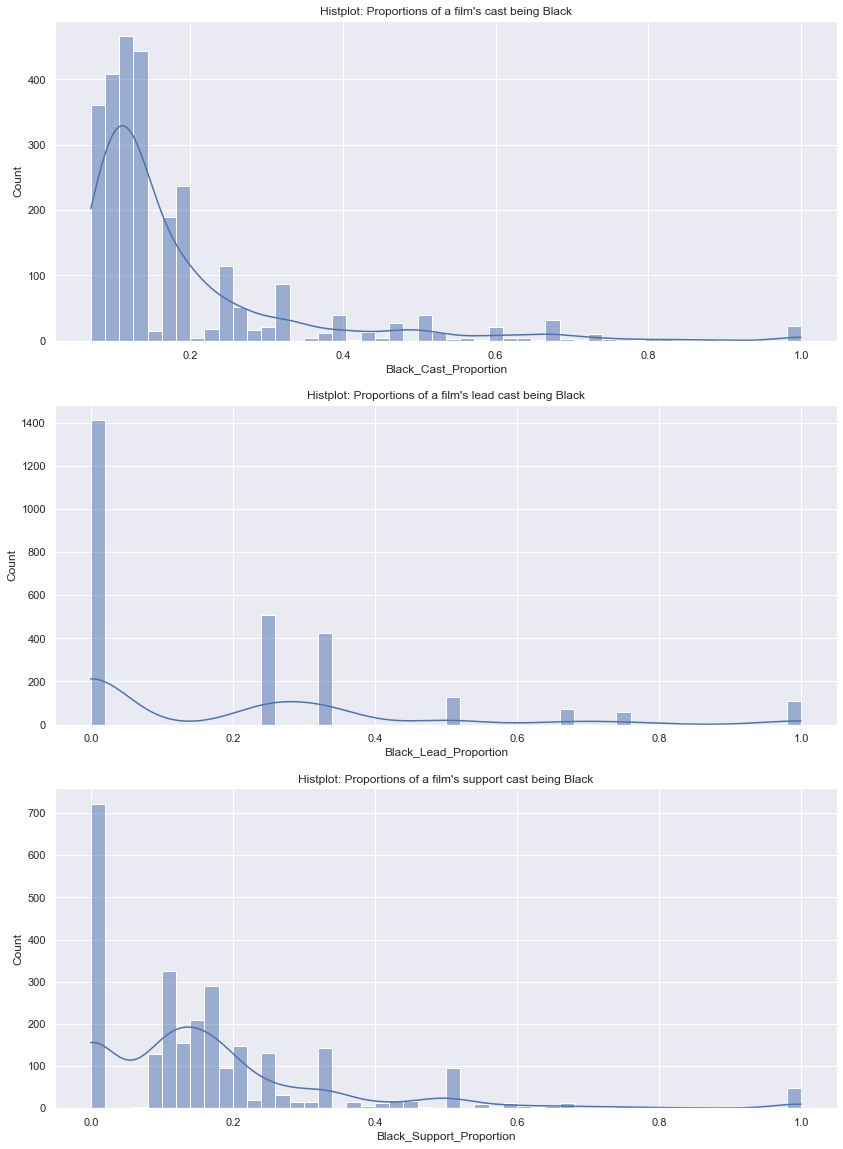

In [540]:
# Analyse proportions again
sns.set_theme(style="darkgrid")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 20))

sns.histplot(data=movie_data_df, x="Black_Cast_Proportion", kde=True, bins=50, ax=ax1)
ax1.set_title("Histplot: Proportions of a film's cast being Black")

sns.histplot(data=movie_data_df, x="Black_Lead_Proportion", kde=True, bins=50, ax=ax2)
ax2.set_title("Histplot: Proportions of a film's lead cast being Black")

sns.histplot(data=movie_data_df, x="Black_Support_Proportion", kde=True, bins=50, ax=ax3)
ax3.set_title("Histplot: Proportions of a film's support cast being Black")

In [545]:
movie_data_df[(movie_data_df["Black_Lead_Proportion"] == 0.0) & (movie_data_df["Black_Cast_Proportion"] < 0.1)]

,index,imdbID,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,...,Total_Awards_Lead_Actors,Total_Awards_Supporting_Actors,Total_Awards_Movie_Cast,Total_Awards_Director,Total_Awards_Writer,Total_Awards_Movie_Crew,Total_Awards_Soundtrack_Credits,Black_Lead_Proportion,Black_Support_Proportion,Black_Cast_Proportion
2,2,tt0066559,What Do You Say to a Naked Lady?,1970,X,1970-02-18 00:00:00+00:00,85,"[DOCUMENTARY, COMEDY]",[ALLEN FUNT],[ALLEN FUNT],...,0,0,0,0,0,0,0,0.0,0.12,0.08
15,35,tt0084488,Permanent Vacation,1980,Unrated,1984-04-25 00:00:00+00:00,75,"[COMEDY, DRAMA]",[JIM JARMUSCH],[JIM JARMUSCH],...,0,0,0,0,0,0,0,0.0,0.10,0.08
16,39,tt0085176,Antony and Cleopatra,1984,None,1984-10-05 00:00:00+00:00,179,"[DRAMA, HISTORY, ROMANCE]",[LAWRENCE CARRA],[WILLIAM SHAKESPEARE],...,2,0,2,0,0,0,0,0.0,0.14,0.09
20,46,tt0086877,Alphabet City,1984,R,1984-11-26 00:00:00+00:00,85,"[CRIME, DRAMA, THRILLER]",[AMOS POE],"[GREGORY K. HELLER, AMOS POE, ROBERT SEIDMAN]",...,0,0,0,0,0,0,0,0.0,0.12,0.09
51,110,tt0095825,Party Line,1988,R,1988-10-01 00:00:00+00:00,91,[THRILLER],[WILLIAM WEBB],"[RICHARD BRANDES, TOM BYRNES]",...,1,1,2,0,0,0,0,0.0,0.11,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2692,8002,tt8652584,Hell on the Border,2019,R,2019-12-13 00:00:00+00:00,106,"[ADVENTURE, BIOGRAPHY, WESTERN]",[WES MILLER],[WES MILLER],...,1,0,1,0,0,0,0,0.0,0.11,0.08
2700,8058,tt9031484,House of Cardin,2019,None,2020-09-15 00:00:00+00:00,95,[DOCUMENTARY],"[P. DAVID EBERSOLE, TODD HUGHES]",[NAN],...,0,4,4,0,40,1,0,0.0,0.12,0.09
2703,8081,tt9144756,Rattlesnakes,2019,None,2019-12-27 00:00:00+00:00,85,[THRILLER],[JULIUS AMEDUME],"[JULIUS AMEDUME, GRAHAM FARROW]",...,0,0,0,0,0,0,0,0.0,0.10,0.08
2709,8139,tt9608818,Our Friend,2019,R,2021-01-29 00:00:00+00:00,124,"[DRAMA, ROMANCE]",[GABRIELA COWPERTHWAITE],"[BRAD INGELSBY, MATTHEW TEAGUE]",...,0,2,2,0,0,4,26,0.0,0.10,0.08


In [ ]:
movie_data_df[(movie_data_df["Black_Lead_Proportion"] == 0.0) & (movie_data_df["Black_Cast_Proportion"] < 0.1)]

In [546]:
indexes_to_remove = movie_data_df[(movie_data_df["Black_Lead_Proportion"] == 0.0) & (movie_data_df["Black_Cast_Proportion"] < 0.1)].index

In [548]:
movie_data_df = movie_data_df.loc[~movie_data_df.index.isin(indexes_to_remove)]

In [549]:
movie_data_df

,index,imdbID,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,...,Total_Awards_Lead_Actors,Total_Awards_Supporting_Actors,Total_Awards_Movie_Cast,Total_Awards_Director,Total_Awards_Writer,Total_Awards_Movie_Crew,Total_Awards_Soundtrack_Credits,Black_Lead_Proportion,Black_Support_Proportion,Black_Cast_Proportion
0,0,tt0056952,The Cool World,1963,None,1964-11-02 00:00:00+00:00,105,"[CRIME, DRAMA]",[SHIRLEY CLARKE],"[SHIRLEY CLARKE, CARL LEE, WARREN MILLER]",...,0,0,0,0,0,2,0,0.00,0.20,0.15
1,1,tt0065944,King: A Filmed Record... Montgomery to Memphis,1970,None,1970-03-24 00:00:00+00:00,185,"[DOCUMENTARY, BIOGRAPHY, HISTORY]","[SIDNEY LUMET, JOSEPH L. MANKIEWICZ]","[MITCHELL GRAYSON, ELY A. LANDAU]",...,10,15,25,1,0,4,0,0.50,0.08,0.18
3,3,tt0067741,Shaft,1971,R,1971-07-02 00:00:00+00:00,100,"[ACTION, CRIME, THRILLER]",[GORDON PARKS],"[ERNEST TIDYMAN, JOHN D.F. BLACK, ERNEST TIDYMAN]",...,0,0,0,0,0,3,0,0.50,0.00,0.13
4,4,tt0068358,Charley-One-Eye,1973,R,1973-04-18 00:00:00+00:00,96,[WESTERN],[DON CHAFFEY],[KEITH LEONARD],...,1,0,1,0,0,2,0,0.25,0.00,0.12
5,6,tt0068592,Firehouse,1973,Unrated,1973-01-02 00:00:00+00:00,74,"[ACTION, DRAMA]",[ALEX MARCH],[FRANK CUCCI],...,0,1,1,0,0,0,0,0.00,0.17,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2708,8137,tt9598214,Naked Singularity,2021,R,2021-08-13 00:00:00+00:00,93,"[COMEDY, CRIME, DRAMA]",[CHASE PALMER],"[CHASE PALMER, SERGIO DE LA PAVA, DAVID MATTHEWS]",...,0,3,3,0,0,4,0,0.00,0.17,0.13
2710,8147,tt9677806,Peter Lindbergh - Women's Stories,2019,None,2019-05-30 00:00:00+00:00,113,[DOCUMENTARY],[JEAN-MICHEL VECCHIET],[NAN],...,0,0,0,0,38,0,0,0.33,0.00,0.17
2711,8148,tt9684220,Bad Trip,2021,Unrated,2021-03-26 00:00:00+00:00,86,[COMEDY],[KITAO SAKURAI],"[ERIC ANDRÉ, KITAO SAKURAI, ANDREW BARCHILON]",...,0,0,0,0,0,1,18,0.00,0.17,0.11
2712,8160,tt9760132,Amish Abduction,2019,None,2019-11-09 00:00:00+00:00,87,[THRILLER],[ALI LIEBERT],[ERIC WEINSTOCK],...,0,0,0,0,0,0,0,0.00,0.17,0.10


Text(0.5, 1.0, "Histplot: Proportions of a film's support cast being Black")

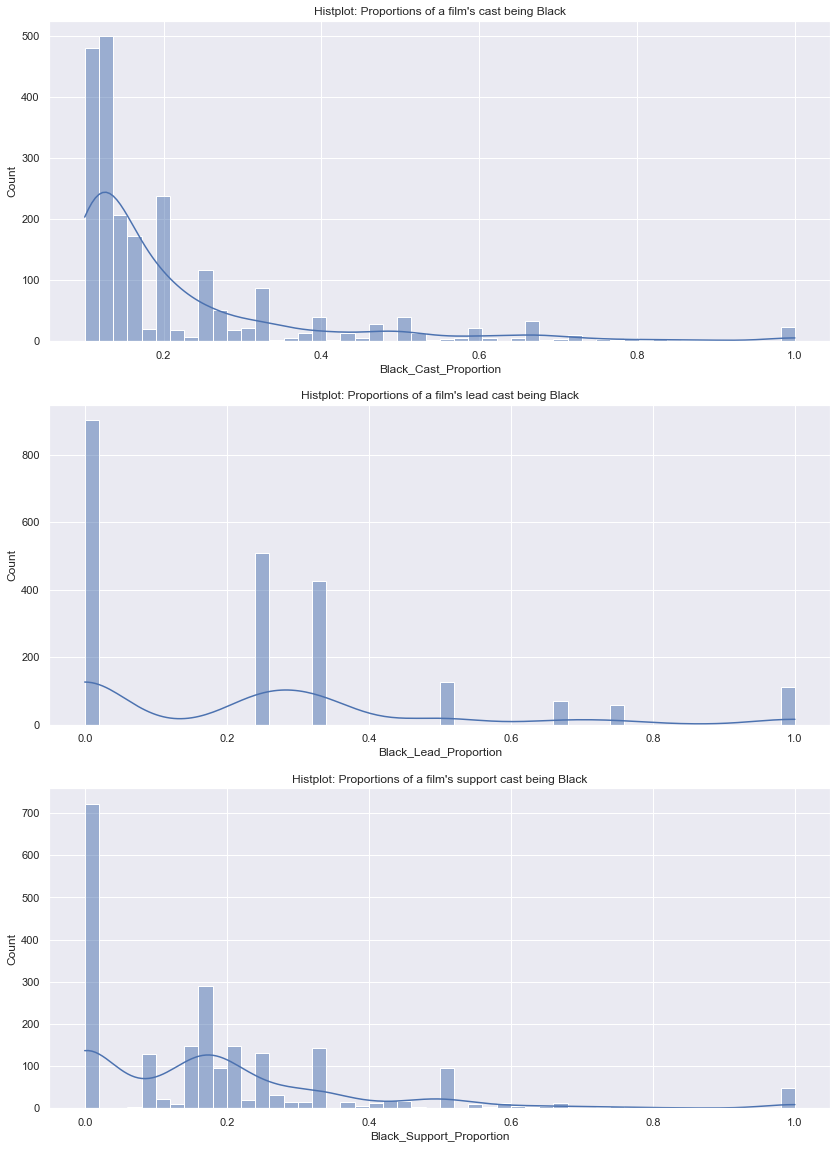

In [550]:
# Analyse proportions again
sns.set_theme(style="darkgrid")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 20))

sns.histplot(data=movie_data_df, x="Black_Cast_Proportion", kde=True, bins=50, ax=ax1)
ax1.set_title("Histplot: Proportions of a film's cast being Black")

sns.histplot(data=movie_data_df, x="Black_Lead_Proportion", kde=True, bins=50, ax=ax2)
ax2.set_title("Histplot: Proportions of a film's lead cast being Black")

sns.histplot(data=movie_data_df, x="Black_Support_Proportion", kde=True, bins=50, ax=ax3)
ax3.set_title("Histplot: Proportions of a film's support cast being Black")

In [552]:
movie_data_df.reset_index(drop=True, inplace=True)

In [553]:
movie_data_df

,index,imdbID,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,...,Total_Awards_Lead_Actors,Total_Awards_Supporting_Actors,Total_Awards_Movie_Cast,Total_Awards_Director,Total_Awards_Writer,Total_Awards_Movie_Crew,Total_Awards_Soundtrack_Credits,Black_Lead_Proportion,Black_Support_Proportion,Black_Cast_Proportion
0,0,tt0056952,The Cool World,1963,None,1964-11-02 00:00:00+00:00,105,"[CRIME, DRAMA]",[SHIRLEY CLARKE],"[SHIRLEY CLARKE, CARL LEE, WARREN MILLER]",...,0,0,0,0,0,2,0,0.00,0.20,0.15
1,1,tt0065944,King: A Filmed Record... Montgomery to Memphis,1970,None,1970-03-24 00:00:00+00:00,185,"[DOCUMENTARY, BIOGRAPHY, HISTORY]","[SIDNEY LUMET, JOSEPH L. MANKIEWICZ]","[MITCHELL GRAYSON, ELY A. LANDAU]",...,10,15,25,1,0,4,0,0.50,0.08,0.18
2,3,tt0067741,Shaft,1971,R,1971-07-02 00:00:00+00:00,100,"[ACTION, CRIME, THRILLER]",[GORDON PARKS],"[ERNEST TIDYMAN, JOHN D.F. BLACK, ERNEST TIDYMAN]",...,0,0,0,0,0,3,0,0.50,0.00,0.13
3,4,tt0068358,Charley-One-Eye,1973,R,1973-04-18 00:00:00+00:00,96,[WESTERN],[DON CHAFFEY],[KEITH LEONARD],...,1,0,1,0,0,2,0,0.25,0.00,0.12
4,6,tt0068592,Firehouse,1973,Unrated,1973-01-02 00:00:00+00:00,74,"[ACTION, DRAMA]",[ALEX MARCH],[FRANK CUCCI],...,0,1,1,0,0,0,0,0.00,0.17,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,8137,tt9598214,Naked Singularity,2021,R,2021-08-13 00:00:00+00:00,93,"[COMEDY, CRIME, DRAMA]",[CHASE PALMER],"[CHASE PALMER, SERGIO DE LA PAVA, DAVID MATTHEWS]",...,0,3,3,0,0,4,0,0.00,0.17,0.13
2201,8147,tt9677806,Peter Lindbergh - Women's Stories,2019,None,2019-05-30 00:00:00+00:00,113,[DOCUMENTARY],[JEAN-MICHEL VECCHIET],[NAN],...,0,0,0,0,38,0,0,0.33,0.00,0.17
2202,8148,tt9684220,Bad Trip,2021,Unrated,2021-03-26 00:00:00+00:00,86,[COMEDY],[KITAO SAKURAI],"[ERIC ANDRÉ, KITAO SAKURAI, ANDREW BARCHILON]",...,0,0,0,0,0,1,18,0.00,0.17,0.11
2203,8160,tt9760132,Amish Abduction,2019,None,2019-11-09 00:00:00+00:00,87,[THRILLER],[ALI LIEBERT],[ERIC WEINSTOCK],...,0,0,0,0,0,0,0,0.00,0.17,0.10
